# Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score

# Data Preprocessing

In [42]:
# Read CSV
df = pd.read_csv("./data/data.csv")
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.81667,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.81667,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.81667,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.81667,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.81667,-6.2,6942.0


In [43]:
# Check Total Unique Values in Location
unique_locations = df['Location'].nunique()

# Check total nulls
nullcounter = df.isnull().sum()
print("Total Unique Locations: ", unique_locations)
print(nullcounter)

Total Unique Locations:  2
Customer ID                     0
Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
Churn Label                     0
Longitude                       0
Latitude                        0
CLTV (Predicted Thou. IDR)      0
dtype: int64


In [44]:
# Drop Customer ID
df = df.drop(columns="Customer ID")

# Replace Values
df = df.replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['Location'] = df['Location'].map({'Jakarta': 1, 'Bandung': 0})
df['Payment Method'] = df['Payment Method'].map({'Digital Wallet': 0, 'Pulsa': 1, 'Debit': 2, 'Credit': 3})
df['Device Class'] = df['Device Class'].map({'Low End': 0, 'Mid End': 1, 'High End': 2})
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,2,1,1,1,1,0,0,0,0,0,70.005,1,106.81667,-6.2,4210.7
1,2,1,2,0,0,0,0,0,0,1,91.910,1,106.81667,-6.2,3511.3
2,8,1,2,0,0,1,0,1,1,1,129.545,1,106.81667,-6.2,6983.6
3,28,1,2,0,0,1,1,1,1,1,136.240,1,106.81667,-6.2,6503.9
4,49,1,2,0,1,1,0,1,1,2,134.810,1,106.81667,-6.2,6942.0


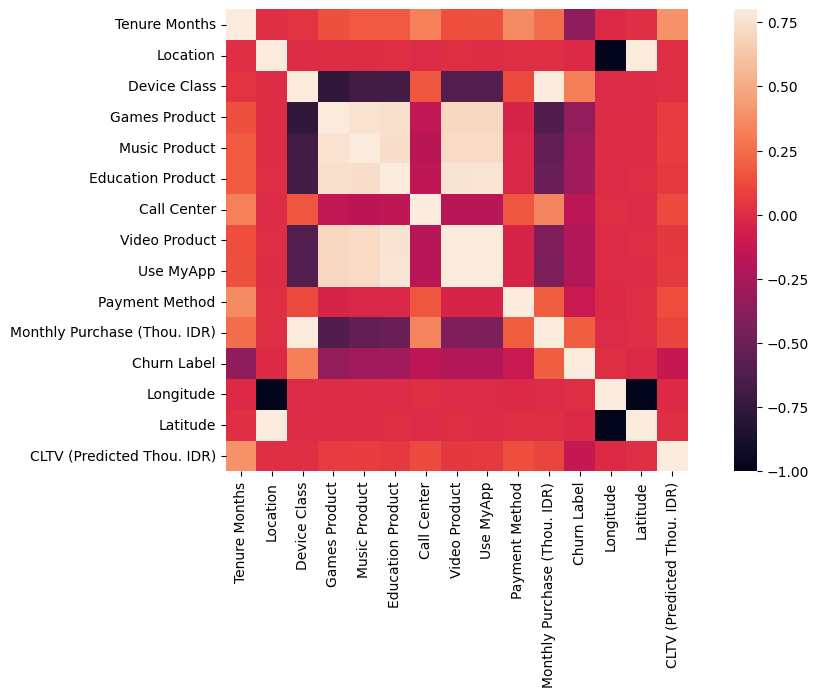

In [45]:
# Get Correlation Matrix
corrmat= df.corr()
fig = plt.figure(figsize = (12 ,6))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [46]:
# Read CSV and Drop Customer ID
df = pd.read_csv("./data/data.csv").drop(columns="Customer ID")

# Replace Values
df = df.replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['Location'] = df['Location'].map({'Jakarta': 1, 'Bandung': 0})

# One hot encode Location and Device Class column
df_encoded = pd.get_dummies(df, columns=['Device Class'], prefix='is', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['Payment Method'], prefix='use', dtype=int)

# Move the "Churn Label" column to the right
churn_label = df_encoded.pop('Churn Label')  # Remove the column
df_encoded['Churn Label'] = churn_label 
df_encoded.head()

,Tenure Months,Location,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR),is_High End,is_Low End,is_Mid End,use_Credit,use_Debit,use_Digital Wallet,use_Pulsa,Churn Label
0,2,1,1,1,0,0,0,0,70.005,106.81667,-6.2,4210.7,0,0,1,0,0,1,0,1
1,2,1,0,0,0,0,0,0,91.910,106.81667,-6.2,3511.3,1,0,0,0,0,0,1,1
2,8,1,0,0,1,0,1,1,129.545,106.81667,-6.2,6983.6,1,0,0,0,0,0,1,1
3,28,1,0,0,1,1,1,1,136.240,106.81667,-6.2,6503.9,1,0,0,0,0,0,1,1
4,49,1,0,1,1,0,1,1,134.810,106.81667,-6.2,6942.0,1,0,0,0,1,0,0,1


# Machine Learning

In [55]:
# Split Into Training and Test Set
X, Y = df_encoded.drop(columns=["Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Churn Label"]), df_encoded["Churn Label"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [56]:
# Create and train the Random Forest model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, Y_train)
    
# Evaluate the model
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8041163946061036


In [58]:
# Split Into Training and Test Set
X, Y = df_encoded.drop(columns=["Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Churn Label"]), df_encoded["CLTV (Predicted Thou. IDR)"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [59]:
# Regression Model to Predict CLTV
regmodel = LinearRegression()
regmodel.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = regmodel.predict(X_test)

# Calculate performance metrics
mse = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
std = df["CLTV (Predicted Thou. IDR)"].values.std()

print("Dataset Standard Deviation:", std)
print("Mean Absolute Error:", mse)
print("R-squared (R2) Score:", r2)

Dataset Standard Deviation: 1537.8651090608005
Mean Absolute Error: 1195.4085817102011
R-squared (R2) Score: 0.1727984526563291


In [45]:
# Export Churn Model
with open('./model/churnmodel.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Export CLTV Model
with open('./model/cltvmodel.pkl', 'wb') as model_file:
    pickle.dump(regmodel, model_file)